Tiny Code Challenge 💻

Can you try to write a small snippet (in NumPy or PyTorch, whichever you like) that generates this n x n causal mask given a sequence length n?

👉 Try it for n=5 and check if you get a lower-triangular matrix.

In [2]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.functional import one_hot
import numpy as np
import tiktoken

general mask

In [3]:
import torch

def build_mask_matrix(n : int = 5) -> torch.Tensor:
    """
    Builds a mask matrix of size n x n where the lower triangular part (including the diagonal) is filled with 1s
    and the upper triangular part is filled with 0s.

    Args:
        n (int): The size of the matrix. Default is 5.

    Returns:
        torch.Tensor: The resulting mask matrix.
    """
    mask = torch.tril(torch.ones((n, n), dtype=torch.float32), diagonal=0)
    return mask

print(build_mask_matrix(5))

tensor([[1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1.]])


real masking matrix

In [4]:
def build_real_mask_matrix(n : int = 5) -> torch.Tensor:
    """
    Builds a real mask matrix of size n x n where the lower triangular part (including the diagonal) is filled with 0s
    and the upper triangular part is filled with -inf.

    Args:
        n (int): The size of the matrix. Default is 5.

    Returns:
        torch.Tensor: The resulting real mask matrix.
    """
    mask = torch.triu(torch.ones((n, n), dtype=torch.float32) * float('-inf'), diagonal=1)
    return mask

print(build_real_mask_matrix(5))

tensor([[0., -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0.]])


# Residual Layer

In [5]:
import torch.nn as nn

class ResidualLayer(nn.Module):
    def __init__(self, module: nn.Module):
        super().__init__()
        self.module = module

    def forward(self, x):
        return x + self.module(x)

# Layer Normalization

In [6]:
import torch.nn.functional as F

class LayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        self.normalized_shape = normalized_shape
        self.eps = eps
        self.gamma = nn.Parameter(torch.ones(normalized_shape))
        self.beta = nn.Parameter(torch.zeros(normalized_shape))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        std = x.std(dim=-1, keepdim=True, unbiased=False)
        return self.gamma * (x - mean) / (std + self.eps) + self.beta

# Linear Layer

In [7]:
class LinearLayer(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features, bias=bias)

    def forward(self, x):
        return self.linear(x)
    
class FeedForward(nn.Module):
    def __init__(self, embed_dim, hidden_dim, dropout=0.0):
        super().__init__()
        self.fc1 = LinearLayer(embed_dim, hidden_dim)
        self.act = nn.GELU()
        self.drop1 = nn.Dropout(dropout)
        self.fc2 = LinearLayer(hidden_dim, embed_dim)
        self.drop2 = nn.Dropout(dropout)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop1(x)
        x = self.fc2(x)
        x = self.drop2(x)
        return x

# Multi-Headed Masked Attention Layer

In [8]:
class MultiHeadedMaskedAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        assert embed_dim % num_heads == 0, "embed_dim must be divisible by num_heads"
        self.head_dim = embed_dim // num_heads

        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)
        self.out_proj = nn.Linear(embed_dim, embed_dim)

    def forward(self, x, mask=None):
        batch_size, seq_len, _ = x.size()

        # Project queries, keys, values
        q = self.q_proj(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        k = self.k_proj(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        v = self.v_proj(x).view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)

        # Scaled dot-product attention
        attn_scores = torch.matmul(q, k.transpose(-2, -1)) / (self.head_dim ** 0.5)
        if mask is not None:
            attn_scores = attn_scores + mask.unsqueeze(0).unsqueeze(1)
        attn_weights = torch.softmax(attn_scores, dim=-1)
        attn_output = torch.matmul(attn_weights, v)

        # Concatenate heads and project
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, seq_len, self.embed_dim)
        return self.out_proj(attn_output)

# Full Block

In [9]:
class DecoderBlock(nn.Module):
    """
    Pre-Norm GPT-style block using your components:
      y = x + Attn(LN(x), causal_mask)
      z = x + MLP(LN(y))
    """
    def __init__(self, embed_dim: int, num_heads: int, mlp_ratio: float = 4.0, dropout: float = 0.0):
        super().__init__()
        self.ln1 = LayerNorm(embed_dim)
        self.attn = MultiHeadedMaskedAttention(embed_dim, num_heads)
        self.drop_attn = nn.Dropout(dropout)

        hidden = int(mlp_ratio * embed_dim)
        self.ln2 = LayerNorm(embed_dim)
        self.mlp = FeedForward(embed_dim, hidden, dropout=dropout)
        # We can use your ResidualLayer cleanly around the MLP path
        self.mlp_residual = ResidualLayer(self.mlp)

    @staticmethod
    def _causal_mask(T: int, device, dtype):
        # 0 on allowed (<= i), -inf on forbidden (> i)
        mask = torch.full((T, T), float('-inf'), device=device, dtype=dtype)
        mask = torch.triu(mask, diagonal=1)  # upper triangle = -inf; diagonal/lower = 0
        return mask

    def forward(self, x):
        # x: [B, T, D]
        B, T, D = x.shape
        mask = self._causal_mask(T, x.device, x.dtype)  # [T, T]

        # Attention block: pre-norm + residual (manual to pass mask)
        attn_out = self.attn(self.ln1(x), mask=mask)     # [B, T, D]
        x = x + self.drop_attn(attn_out)

        # MLP block: pre-norm + residual (via your ResidualLayer)
        x = self.mlp_residual(self.ln2(x))               # [B, T, D]
        return x

In [21]:
# Generate hyperparameters according to common design choices and store them in UPPER case variables
EMBED_DIM =128
NUM_HEADS = 8
MLP_RATIO = 8.0
DROPOUT = 0.1
tokenizer = tiktoken.get_encoding("gpt2")
VOCAB_SIZE = tokenizer.n_vocab

BATCH_SIZE = 8
SEQ_LEN = 2**10

In [19]:
class TransformerDecoder(nn.Module):
    def __init__(self, 
                 num_layers: int,
                 embed_dim: int = EMBED_DIM,
                 num_heads: int = NUM_HEADS,
                 mlp_ratio: float = MLP_RATIO,
                 dropout: float = DROPOUT,
                 num_embeddings: int = VOCAB_SIZE,
                 max_seq_len: int = SEQ_LEN
                 ):  # Example vocab size for text models
        super().__init__()
        
        self.token_embedding = nn.Embedding(num_embeddings, embed_dim)
        self.position_embedding = nn.Embedding(max_seq_len, embed_dim)

        self.dropout = nn.Dropout(dropout)

        self.layers = nn.ModuleList([
            DecoderBlock(
                embed_dim=embed_dim,
                num_heads=num_heads,
                mlp_ratio=mlp_ratio,
                dropout=dropout
            ) for _ in range(num_layers)
        ])

        self._final_layer = nn.Linear(embed_dim, num_embeddings)
        
        # Layer normalization after final block
        self.norm = LayerNorm(embed_dim)
        
    def forward(self, x):
        # x shape: (batch_size, seq_len) - integer token IDs
        B, T = x.shape
        
        # Get token embeddings
        tok_emb = self.token_embedding(x)  # (B, T, embed_dim)
        
        # Get position embeddings
        positions = torch.arange(T, device=x.device)  # (T,)
        pos_emb = self.position_embedding(positions)  # (T, embed_dim)

        # Combine token and position embeddings
        x = self.dropout(tok_emb + pos_emb)  # (B, T, embed_dim)

        for layer in self.layers:
            x = layer(x)
            
        # Final layer norm
        return self._final_layer(self.norm(x))

# Mock Training

In the following section, given a simple text, we run a mock training.

Steps:
- generate mock text
- tokenize and add positional embeddings
- split in batches
- construct a model
- define train schema
- train and measure training time and total loss

In [12]:
# read war_and_peace.txt 
with open("war_and_peace.txt", "r", encoding="utf-8") as f:
    mock_text = f.read() 

### tokenize text

In [47]:
# Tokenize text
l = len(mock_text)
l = int(.5 * l)
tokenized_text = tokenizer.encode(mock_text[l:])  # Limit to first 10,000 characters for speed
vocab_size = VOCAB_SIZE

# Chunk tokens into sequences of SEQ_LEN
def create_sequences(tokens, seq_len = SEQ_LEN):
    sequences = []
    for i in range(0, len(tokens) - seq_len, seq_len):
        seq = tokens[i:i + seq_len + 1]  # +1 for target
        sequences.append(seq)
    return sequences

sequences = create_sequences(tokenized_text, SEQ_LEN)
print(f"Created {len(sequences)} sequences of length {SEQ_LEN}")

Created 404 sequences of length 1024


### prepare dataset

In [48]:
# Create input-target pairs
inputs = []
targets = []
for seq in sequences:
    inputs.append(seq[:-1])   # All but last token
    targets.append(seq[1:])   # All but first token

# Convert to tensors
inputs = torch.tensor(inputs, dtype=torch.long)   # (num_sequences, SEQ_LEN)
targets = torch.tensor(targets, dtype=torch.long) # (num_sequences, SEQ_LEN)

print(f"Input shape: {inputs.shape}")
print(f"Target shape: {targets.shape}")

dataset = TensorDataset(inputs, targets)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

Input shape: torch.Size([404, 1024])
Target shape: torch.Size([404, 1024])


### prepare model

In [24]:
# Construct model
model = TransformerDecoder(
    num_layers=1,
    max_seq_len=SEQ_LEN
)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

In [30]:
model

TransformerDecoder(
  (token_embedding): Embedding(50257, 128)
  (position_embedding): Embedding(1024, 128)
  (dropout): Dropout(p=0.1, inplace=False)
  (layers): ModuleList(
    (0): DecoderBlock(
      (ln1): LayerNorm()
      (attn): MultiHeadedMaskedAttention(
        (q_proj): Linear(in_features=128, out_features=128, bias=True)
        (k_proj): Linear(in_features=128, out_features=128, bias=True)
        (v_proj): Linear(in_features=128, out_features=128, bias=True)
        (out_proj): Linear(in_features=128, out_features=128, bias=True)
      )
      (drop_attn): Dropout(p=0.1, inplace=False)
      (ln2): LayerNorm()
      (mlp): FeedForward(
        (fc1): LinearLayer(
          (linear): Linear(in_features=128, out_features=1024, bias=True)
        )
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.1, inplace=False)
        (fc2): LinearLayer(
          (linear): Linear(in_features=1024, out_features=128, bias=True)
        )
        (drop2): Dropout(p=0.1

### Define train function

In [31]:
def train_model(model, dataloader, criterion, optimizer, epochs=1):
    model.train()
    total_loss = 0
    start_time = time.time()
    loss_by_epoch = []
    
    for epoch in range(epochs):
        epoch_loss = 0
        for batch_data, batch_labels in dataloader:
            # batch_data shape: (batch_size, seq_len)
            # batch_labels shape: (batch_size, seq_len)
            
            optimizer.zero_grad()
            
            # Forward pass - model handles embedding internally
            outputs = model(batch_data)  # (batch_size, seq_len, vocab_size)
            
            # Reshape for CrossEntropyLoss
            # outputs: (batch_size * seq_len, vocab_size)
            # labels: (batch_size * seq_len,)
            loss = criterion(
                outputs.view(-1, vocab_size),  # Use vocab_size instead of outputs.size(-1)
                batch_labels.view(-1)
            )
            
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        loss_by_epoch.append(epoch_loss)
        total_loss += epoch_loss
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")
    
    end_time = time.time()
    print(f"Training completed in {end_time - start_time:.2f} seconds")
    print(f"Average Loss: {total_loss/epochs:.4f}")
    return loss_by_epoch

In [ ]:
# Train the model
loss = train_model(model, dataloader, criterion, optimizer, epochs=10)
print(loss)

Epoch 1/10, Loss: 273.6794


Matplotlib is building the font cache; this may take a moment.


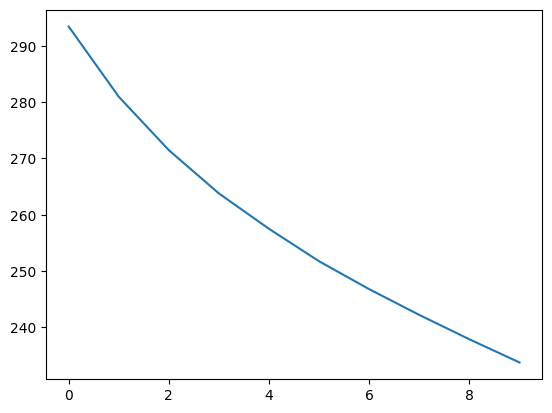

In [44]:
import matplotlib.pyplot as plt

plt.plot(loss)

In [45]:
def predict_next_word(sentence: str):
    """
    Generates up to SEQ_LEN additional tokens for `sentence`.
    Truncates input to the model's position embedding max length to avoid index errors.
    """
    # Determine model device and max positional length
    device = next(model.parameters()).device
    max_pos = model.position_embedding.num_embeddings  # maximum supported sequence length

    for _ in range(SEQ_LEN):
        tokens = tokenizer.encode(sentence)
        if len(tokens) == 0:
            return sentence

        # Truncate to last max_pos tokens (keep most recent context)
        if len(tokens) > max_pos:
            tokens = tokens[-max_pos:]

        encoded_text = torch.tensor(tokens, dtype=torch.long, device=device).unsqueeze(0)  # (1, T)

        with torch.no_grad():
            output = model(encoded_text)  # (1, T, vocab_size)

        next_token_logits = output[0, -1, :]  # logits for last position
        next_token_id = int(torch.argmax(next_token_logits).item())

        # If tokenizer defines an EOT token id, stop generation
        eot_id = getattr(tokenizer, "eot_token", None)
        if eot_id is not None and next_token_id == eot_id:
            return sentence

        # Append decoded token (tokenizer.decode usually returns proper spacing)
        sentence += tokenizer.decode([next_token_id])

    return sentence


In [46]:
sentence = "War and Peace has a number of chapters equals to"
result = predict_next_word(sentence)
print(result)

War and Peace has a number of chapters equals to




the



                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            